# Predicting Concrete Strength from Mix Ingredients Using Machine Learning

#### Matthew Williams, PE
#### June 13th, 2024

## 1. Introduction

Concrete is a unique building material that has high compressive strength and relatively low tensile strength. A concrete mix is designed by engineers that specialize in creating a "recipe" to ensure certain material properties, one of which is the design strength.

The production of concrete starts by mixing the dry ingredients and then adding water to start a chemical reaction that causes it to cure. As concrete cures its strength increases. This is a non-linear development of strength whereby the concrete quickly develops strength and after this initial period, strength development slows down but still continues long after the hardened concrete goes into service.

Engineers consider the 28 day compressive strength of concrete as the design strength. This is the strength used to design buildings, bridges, and roadways for example. This project looks at a dataset of 1030 samples of concrete. These samples were mixed, aged, and cast as test cylinders that were then crushed to determine the breaking strength of the sample. For each cylinder, the dataset includes the mix ingredient amounts, age of the cylinder, and the breaking strength.

This project seeks to predict the 28 day breaking strength of the samples based on the mix and age of the sample.

## 2. Setup
### 2.1 Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
import math
from google.colab import drive

### 2.2 Read Data into a Dataframe

For ease of processing the dataset is read into a pandas DataFrame. At the same time, a couple of the attribute names are shortened.

In [ ]:
drive.mount('/content/drive/')

# Read the data from csv file
concrete_data = pd.read_csv('../content/drive/MyDrive/Colab/concrete_data.csv')

# Rename 'blast_furnace_slag' & 'concrete_compressive_strength' for easier reading and referencing
concrete_data = concrete_data.rename(columns = {'blast_furnace_slag': 'slag', 'concrete_compressive_strength': 'strength'})

In [ ]:
print('Total number of nan values: ', concrete_data.isna().sum().sum())

Total number of nan values:  0


No 'nan' values were found in the dataset and can be further explored.

## 3. Data Exploration
### 3.1 Preview of Records

Below are the first five records of the dataset. The quantities for each ingredient are given as well as the age of the concrete in days and the strength in megapascals.

In [ ]:
concrete_data.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


### 3.2 Basic Statistics

The basic statistics for each attribute are shown below. A total of 1030 records are included.

In [ ]:
concrete_data.describe()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


### 3.3 Linear Correlation Matrix

The first step in understanding how the mix ingredeints and sample age contribute to the breaking strength a linear correlation matrix can be used. The Pearson method has been used here to create the matrix and a heatmap of the matrix is produced for easier interpretation.

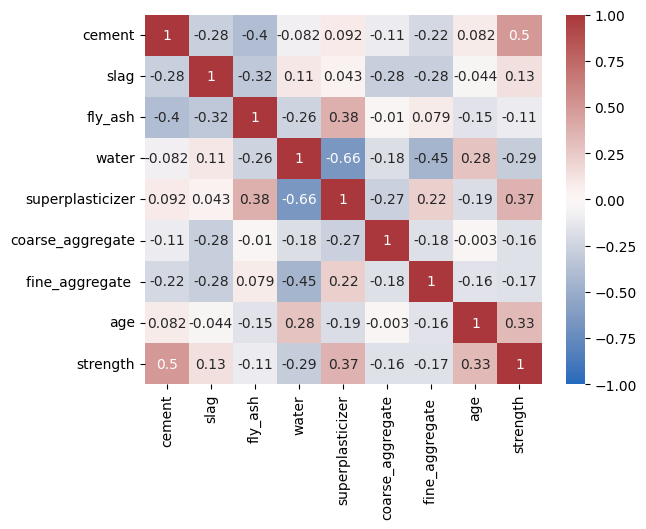

In [ ]:
# Create a correlation matrix
matrix = concrete_data.iloc[:, 0:9].corr(
    method = 'pearson',
)

# Plot correlation matrix & color by coefficient values
sns.heatmap(matrix, annot=True,
           vmax = 1,
           vmin = -1,
           center = 0,
           cmap = 'vlag');

Looking through the various correlation coefficients the highest correlation exists between water and superplasticizers. They share a negative correlation coefficient of 0.66. Thus, as the amount of superplasticizer increases, the amount of water used decreases.

Focusing on the attribute's correlation to concrete strength the highest correlation coefficient is with the cement content. Logically, this makes sense as cement is the adhesive that binds the aggregates together. Using higher cement ratios leads to higher strength concrete. The second and third most influential attributes are superplasticizers and the age of the concrete.

### 3.4  Pair Plots

Not all relationships are linear. By plotting each attribute against the others, non-linear relationships can be revealed. An example of a non-linear relationship could be superplasticizer and water. While those attributes had the strongest linear relationship, it could be that these two attributes have a stronger non-linear relationship.

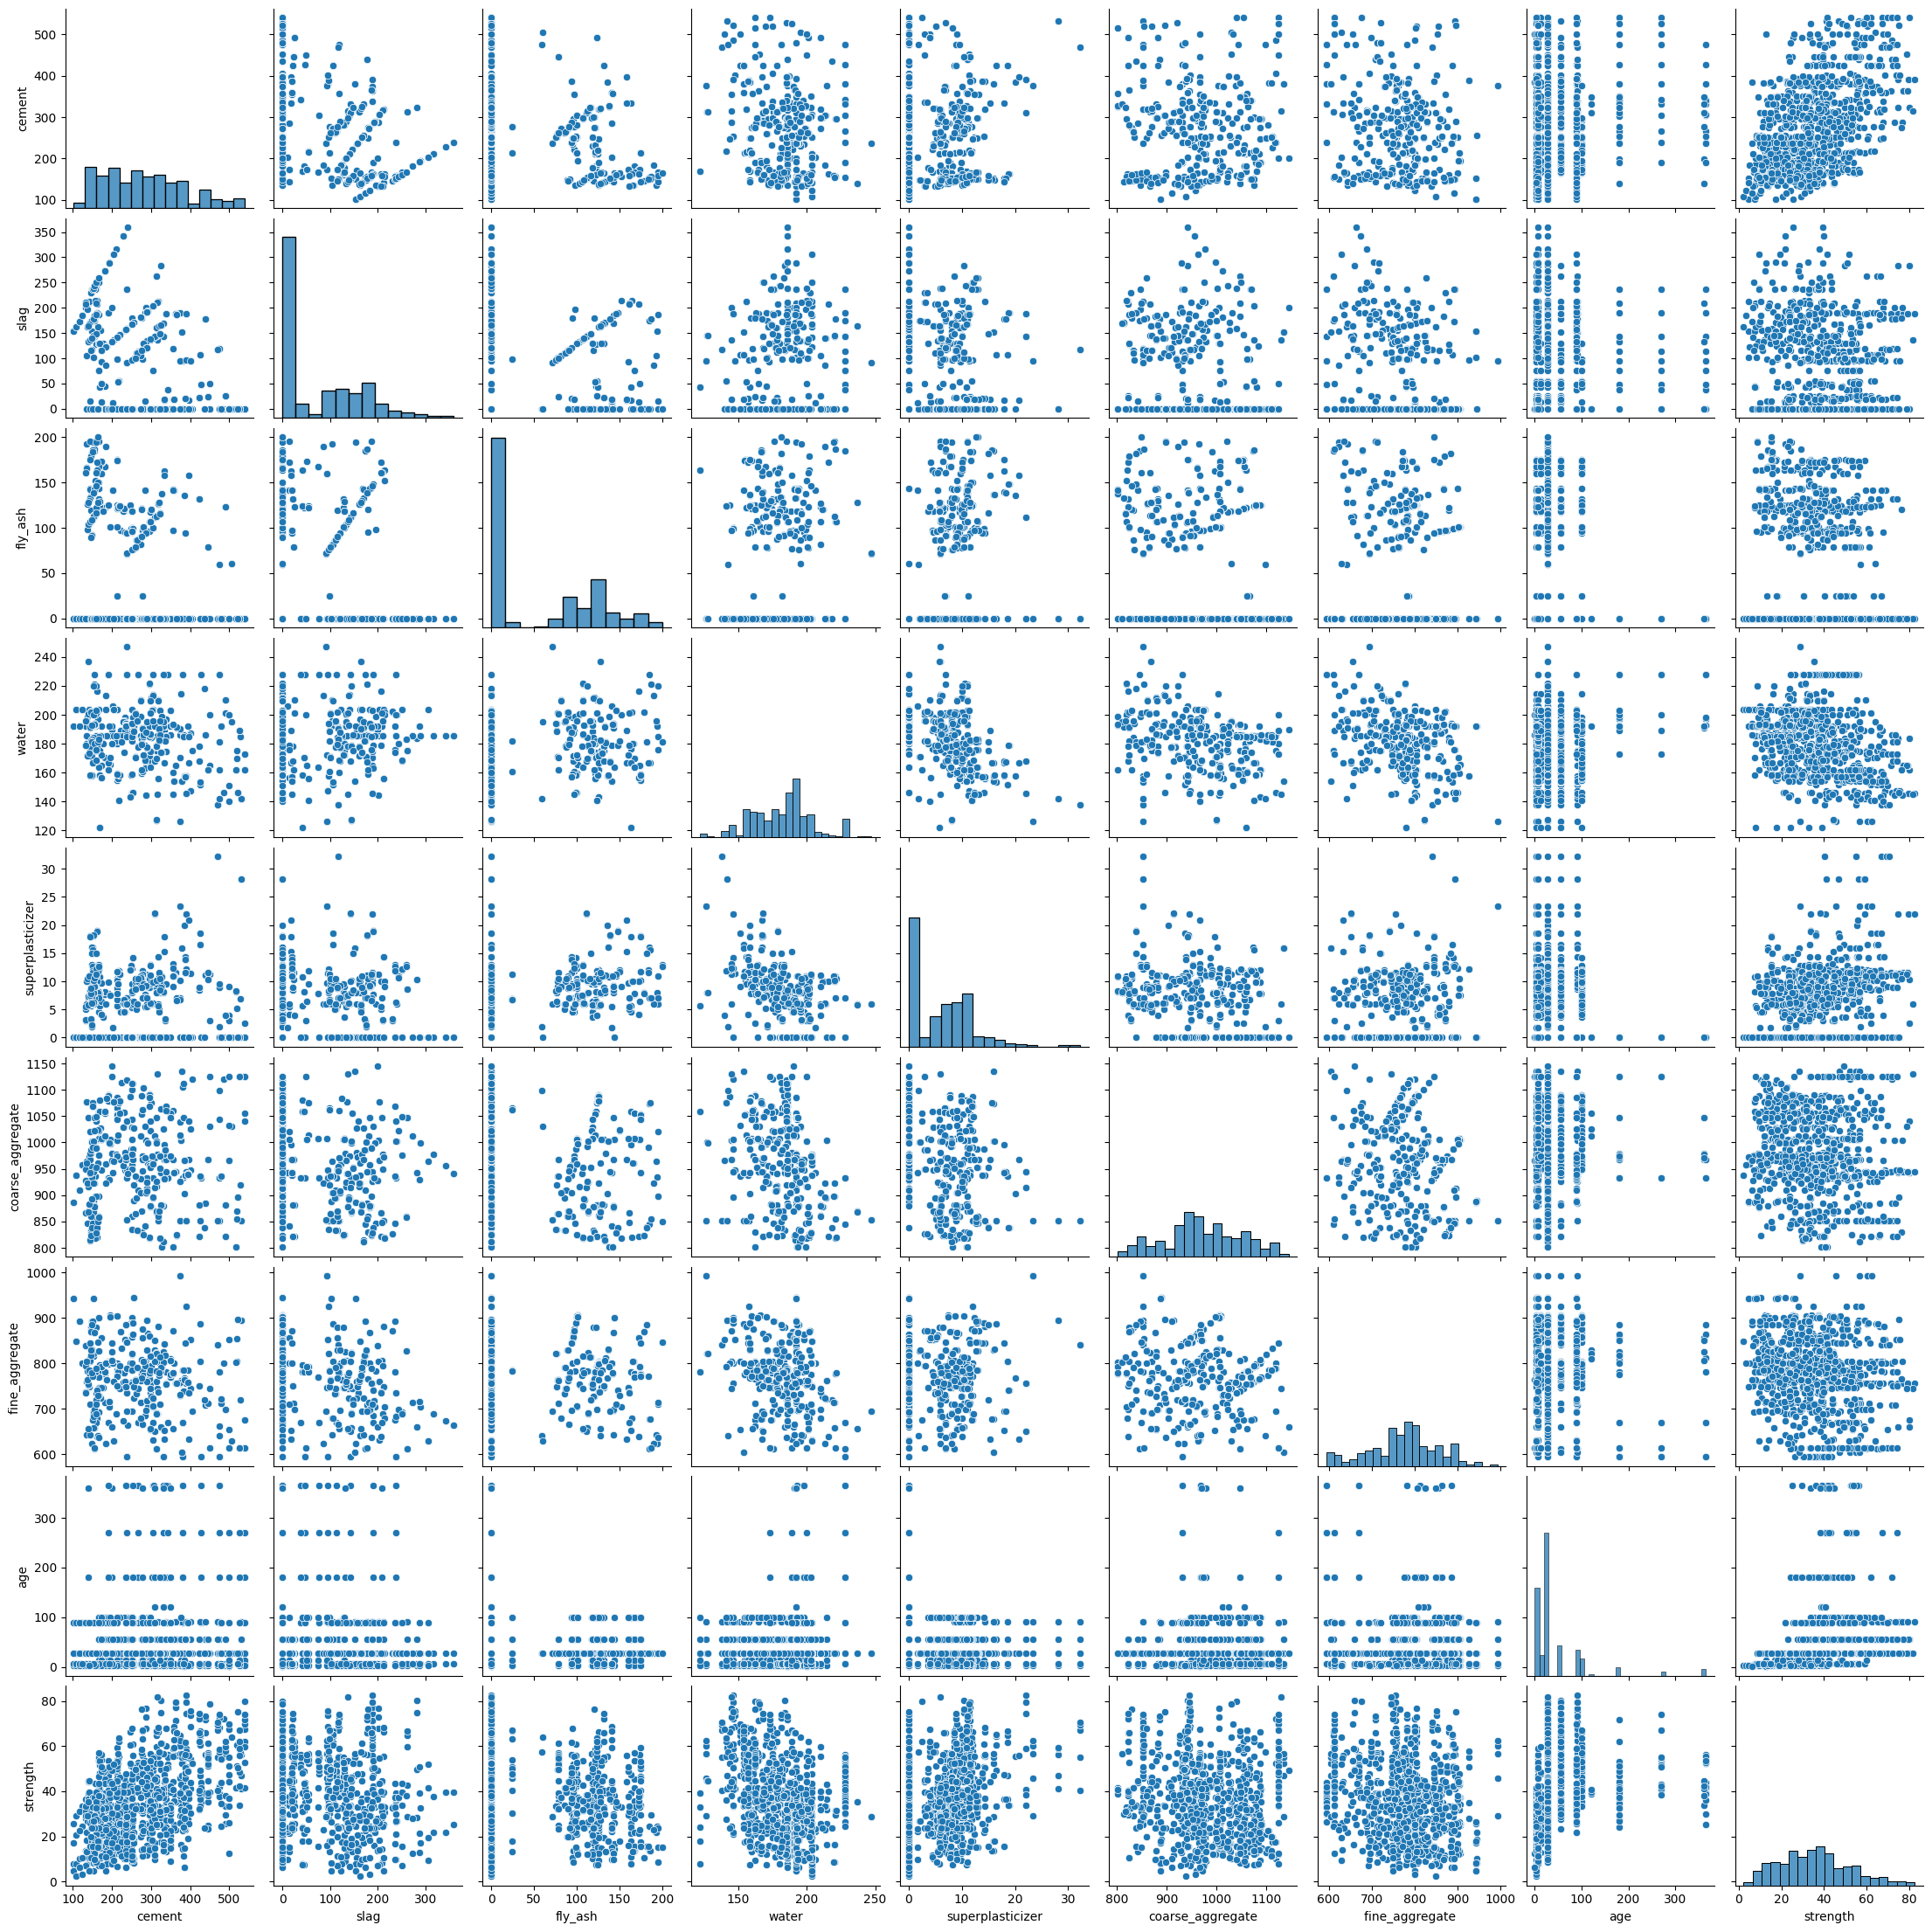

In [ ]:
sns.pairplot(concrete_data.iloc[:, 0:9]);

## 4. Prepare the Data
### 4.1 Concatenate Attribute Values to Create a Unique Identifier For Each Mix

No mix ID or was included in the dataset so it is not clear whether or not the dataset includes 1030 independent tests or if the same mixes were tested at different ages as is typically done in the construction industry. In order to group samples by their mix the values for each of the ingredients are converted to text strings and then concatenated to create a string ID for each mix.

In [ ]:
# Concatenate mix ingredients as strings to create a unique mix identifier
concrete_data['mix_as_string'] = concrete_data['cement'].astype(str) + concrete_data['slag'].astype(str) + \
                                 concrete_data['fly_ash'].astype(str) + concrete_data['water'].astype(str) + \
                                 concrete_data['superplasticizer'].astype(str) + concrete_data['coarse_aggregate'].astype(str) + \
                                 concrete_data['fine_aggregate '].astype(str)

concrete_data.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength,mix_as_string
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,540.00.00.0162.02.51040.0676.0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,540.00.00.0162.02.51055.0676.0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,332.5142.50.0228.00.0932.0594.0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,332.5142.50.0228.00.0932.0594.0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,198.6132.40.0192.00.0978.4825.5


In [ ]:
print('Number of unique mixes: ', len(concrete_data['mix_as_string'].unique()))

Number of unique mixes:  427


Counting only unique mix IDs indicates that the 1030 test samples were created from 427 unique mix "recipes".

### 4.2 Create a DataFrame with Only 28 Day Strengths

The intention of this project is to determine if the 28 day strength of mix designs can be predicted based on the mix contents. To this end, a new dataframe is needed with only the 28 day breaking strenths.

In [ ]:
# Make a copy of concrete_data with only the records where the age is 28 days
mix_data = concrete_data.loc[concrete_data['age'] == 28].copy()
mix_data.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength,mix_as_string
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,540.00.00.0162.02.51040.0676.0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,540.00.00.0162.02.51055.0676.0
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45,380.095.00.0228.00.0932.0594.0
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,266.0114.00.0228.00.0932.0670.0
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.29,475.00.00.0228.00.0932.0594.0


## 5. Regression Modeling

Two regression models are used here in order to maximize the outcome of this project. The first is a multi-variable linear regression model that can use each of the attributes as input. After evaluating the performance of this model, a second model is created using the k Nearest Neighbors Regressor (kNeighborsRegressor) which could be better at picking up on non-linear relationships between the attributes and the concrete strength.

### 5.1 Split the data into testing and training datasets

The 28 day breaking strength dataframe will now be separated into a training dataset and a testing dataset. Given the small size of the dataset, the training dataset will have 85% of the records and the remaining 15% will be taken as the testing dataset. The model is built using all attributes from the above dataframe except for the age of the samples.

In [ ]:
# Set X & y for regression analysis
X = np.array(mix_data.iloc[:, range(0,7)])
y = np.array(mix_data['strength']).reshape((-1,1))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5)

### 5.2 Multi-Linear Regression Model

Here the linear regression model is built and trained on the training set.

In [ ]:
# Create a multi-linear regression model
multi_model = LinearRegression()
multi_model = LinearRegression(fit_intercept = True).fit(x_train,y_train)
r_squared = round(multi_model.score(x_train,y_train),2)
print('r_squared:', r_squared)

r_squared: 0.78


The above linear model produced an r squared value of 0.78. While this shows some ability to predict breaking strengths it may be possible to produce a model that performs better. Before moving on though, the plot below shows the relationship between the actual breaking strength of the test dataset against the predicted strength from the model.

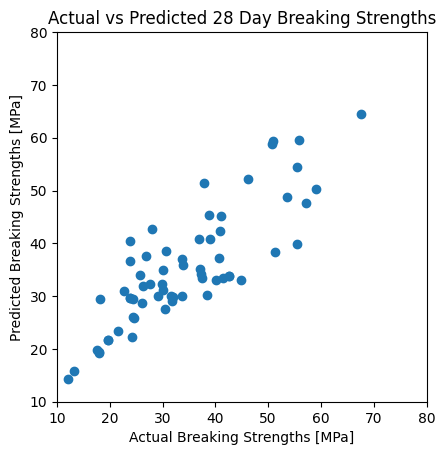

In [ ]:
# Plot predicted vs actual strengths
predictions = multi_model.predict(x_test)
plt.scatter(y_test, predictions)
plt.title('Actual vs Predicted 28 Day Breaking Strengths')
plt.xlabel('Actual Breaking Strengths [MPa]')
plt.ylabel('Predicted Breaking Strengths [MPa]')
plt.axis('scaled')
plt.xlim(10, 80)
plt.ylim(10, 80)
plt.show()

### 5.3 k Nearest Neighbors Regressor

Using the k Nearest Neighbors Regressor (kNNR) requires additional preparation to maximize its potential. First, the training and testing data must be scaled in order to prevent attributes with higher numeric values from having an overinfluence on the outcome. Each attribute is first scaled from zero to one. A sample of the effect of this scaling is shown below.

#### Scale Testing & Training Data

In [ ]:
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_scaled

array([[0.47488584, 0.39788536, 0.55472264, ..., 0.68322981, 0.32848837,
        0.1430005 ],
       [0.34200913, 0.        , 0.49925037, ..., 0.38509317, 0.59593023,
        0.76718515],
       [0.73515982, 0.06121313, 0.65967016, ..., 0.27639752, 0.06104651,
        0.39136979],
       ...,
       [0.03196347, 0.48135782, 0.        , ..., 0.        , 0.31627907,
        0.74736578],
       [0.4086758 , 0.        , 0.        , ..., 0.        , 0.88081395,
        0.45158053],
       [0.41552511, 0.33305509, 0.        , ..., 0.22360248, 0.49244186,
        0.5022579 ]])

When using kNNR, the user must select the number of neighbors (k) that the model should consider when predicting the breaking strength of the test data. The performance of the model will vary depening upon the number of neighbors chosen. To optimize this model, a loop is run that builds a model incrementing the number of neighbors with each pass. k is varied from 1 to 20 here and a model score is determined for each run.

A plot of the model scores and the number of neighbors used is then created to aid in the selection of k. The highest model score giving the best results from this regressor.

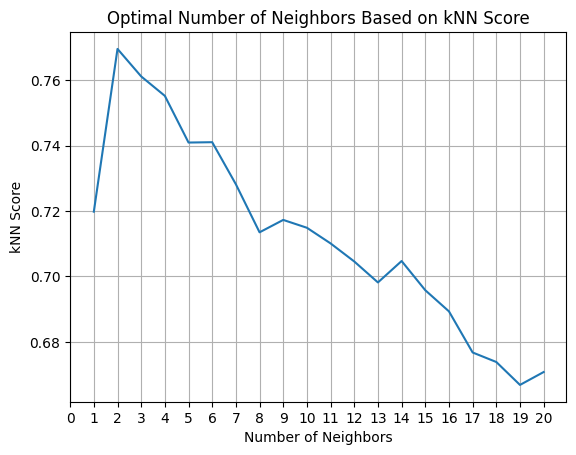

Max kNN Score:  0.77


In [ ]:
neighbors = []
knn_score = []
for i in range(1, 21, 1):
    knn = KNeighborsRegressor(n_neighbors = i)
    knn = knn.fit(x_train_scaled, y_train)
    knn_score.append(knn.score(x_test_scaled,y_test))
    neighbors.append(i)

ax = sns.lineplot(x=neighbors, y=knn_score)
ax.set_xticks(range(0,21), labels=range(0,21))
ax.grid(True, axis='both')
plt.title('Optimal Number of Neighbors Based on kNN Score')
plt.xlabel('Number of Neighbors')
plt.ylabel('kNN Score')
plt.show()

print('Max kNN Score: ', round(max(knn_score),2))

The maximum kNNR model score is 0.77, slightly lower than the r squared value of the linear model. Peak model performance occured when using k = 3. It should be noted that the dataset was split using a particular set of random numbers (random state 7). Changing the random state will change the split of the data which can, in turn, lead to a different k value.

Below, the model is rerun with the k value set to three and a plot of actual vs predicted breaking strengths is again produced.

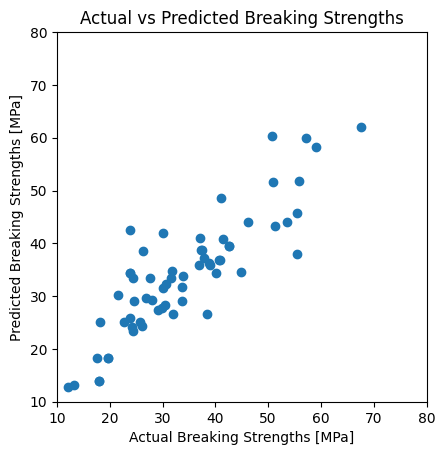

In [ ]:
neighbors = 3
knn = KNeighborsRegressor(n_neighbors = neighbors)
knn = knn.fit(x_train_scaled, y_train)
y_prediction = knn.predict(x_test_scaled)

plt.scatter(y_test, y_prediction);
plt.title('Actual vs Predicted Breaking Strengths')
plt.xlabel('Actual Breaking Strengths [MPa]')
plt.ylabel('Predicted Breaking Strengths [MPa]')
plt.axis('scaled')
plt.xlim(10, 80)
plt.ylim(10, 80)
plt.show();

## 6. Refining the Models

In an effort to increase model performance, additional attributes can be considered in the training and testing datasets. Earlier, the 28 day breaking strengths were isolated from records of all other ages because predicting the 28 day strength is aim of the project. However, model performance may be increased if an initial breaking strength is considered in the data.

### 6.1 Add Measured Attributes for Intial Breaking Strength & Age

Here, new attributes are added for the initial breaking strength of each mix and the age of the sample at that initial break. Using the mix_as_string as a mix ID allows the breaking strengths to be grouped by mix and the minimum age break and its strengt can be determined and appended to each record in the mix data.

The dataset does not contain multiple breaks for all mixes and in some cases, the youngest sample tested was 28 days old. These mixes are not useful in training the model here and are dropped from the dataset.

In [ ]:
# Add attributes for initial strength & age
mix_data['initial_strength'] = ''
mix_data['initial_age'] = ''

# Loop through each mix
for i in mix_data['mix_as_string']:
    # Remove records where the minimum breaking age was 28 days or less
    if min(concrete_data.loc[concrete_data['mix_as_string'] == i]['age']) >= 28:
        mix_data = mix_data.drop(mix_data[mix_data['mix_as_string']==i].index)
    else:
        # Store minimum strength & age to the dataframe
        mix_data.loc[mix_data['mix_as_string'] == i, 'initial_strength'] = min(concrete_data.loc[concrete_data['mix_as_string']==i].strength)
        mix_data.loc[mix_data['mix_as_string'] == i, 'initial_age'] = min(concrete_data.loc[concrete_data['mix_as_string']==i].age)

mix_data.set_index('mix_as_string', inplace=True)
mix_data

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength,initial_strength,initial_age
mix_as_string,,,,,,,,,,,
380.095.00.0228.00.0932.0594.0,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45,32.82,7
475.00.00.0228.00.0932.0594.0,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.29,38.6,7
198.6132.40.0192.00.0978.4825.5,198.6,132.4,0.0,192.0,0.0,978.4,825.5,28,28.02,9.13,3
139.6209.40.0192.00.01047.0806.9,139.6,209.4,0.0,192.0,0.0,1047.0,806.9,28,28.24,8.06,3
427.547.50.0228.00.0932.0594.0,427.5,47.5,0.0,228.0,0.0,932.0,594.0,28,37.43,35.08,7
...,...,...,...,...,...,...,...,...,...,...,...
310.00.00.0192.00.0970.0850.0,310.0,0.0,0.0,192.0,0.0,970.0,850.0,28,27.92,14.99,7
525.00.00.0189.00.01125.0613.0,525.0,0.0,0.0,189.0,0.0,1125.0,613.0,28,55.94,33.8,3
322.00.00.0203.00.0974.0800.0,322.0,0.0,0.0,203.0,0.0,974.0,800.0,28,25.18,20.77,14


### 6.2 Split Data into Testing & Training Datasets

The revised mix_data dataframe is now split into training and testing datasets using the same proportion of records in each as well as the same random number state.

In [ ]:
# Set X & y for regression analysis
X = np.array(mix_data.iloc[:, [0,1,2,3,4,5,6,9,10]])
y = np.array(mix_data['strength']).reshape((-1,1))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5)

### 6.3 Multiple Linear Regression

Re-running the linear regression on the revised dataset yields a much higher r squared value of 0.88. This is much better than the 0.78 from the previous linear regression.

In [ ]:
multi_model = LinearRegression()
multi_model = LinearRegression(fit_intercept = True).fit(x_train,y_train)
r_squared = round(multi_model.score(x_train,y_train),2)
print('r_squared:', r_squared)

r_squared: 0.88


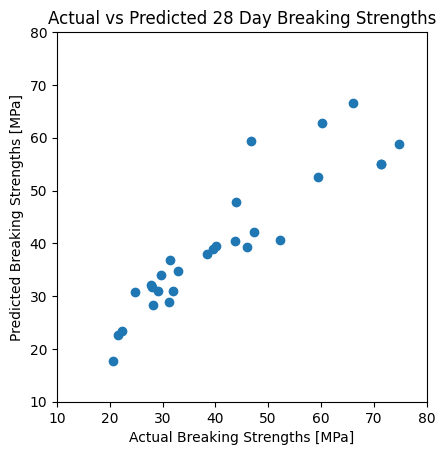

In [ ]:
# Plot predicted vs actual strengths
predictions = multi_model.predict(x_test)
plt.scatter(y_test, predictions)
plt.title('Actual vs Predicted 28 Day Breaking Strengths')
plt.xlabel('Actual Breaking Strengths [MPa]')
plt.ylabel('Predicted Breaking Strengths [MPa]')
plt.axis('scaled')
plt.xlim(10, 80)
plt.ylim(10, 80)
plt.show()

### 6.4 kNeighbors Regressor

The kNeighbors Regressor is run again here for completeness sake.

#### Scale Testing & Training Data

In [ ]:
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_train_scaled

array([[0.25525114, 0.27295492, 0.14064294, ..., 0.48043151, 0.20894257,
        0.15384615],
       [0.24817352, 0.87952142, 0.        , ..., 0.2390868 , 0.39203221,
        0.46153846],
       [0.456621  , 0.        , 0.        , ..., 0.5594581 , 0.31383768,
        1.        ],
       ...,
       [0.46415525, 0.56622148, 0.        , ..., 0.09282489, 0.22928587,
        0.15384615],
       [0.3109589 , 0.44184752, 0.        , ..., 0.35198194, 0.26213181,
        0.46153846],
       [0.52739726, 0.        , 0.        , ..., 0.62368289, 0.26064844,
        0.15384615]])

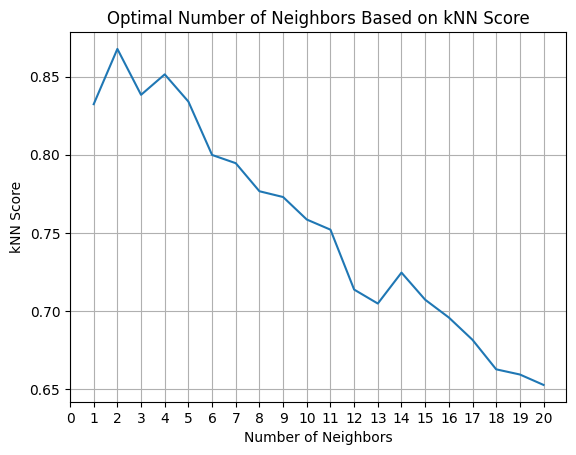

Max kNN Score:  0.87


In [ ]:
neighbors = []
knn_score = []
for i in range(1, 21, 1):
    knn = KNeighborsRegressor(n_neighbors = i)
    knn = knn.fit(x_train_scaled, y_train)
    knn_score.append(knn.score(x_test_scaled,y_test))
    neighbors.append(i)

ax = sns.lineplot(x=neighbors, y=knn_score)
ax.set_xticks(range(0,21), labels=range(0,21))
ax.grid(True, axis='both')
plt.title('Optimal Number of Neighbors Based on kNN Score')
plt.xlabel('Number of Neighbors')
plt.ylabel('kNN Score')
plt.show()

print('Max kNN Score: ', round(max(knn_score),2))

Similar to the linear regression, the kNN score has increased by 13%. The linear regression remains the stronger model of the two.

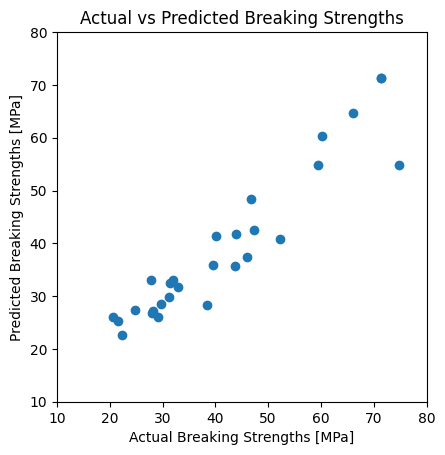

In [ ]:
neighbors = 2
knn = KNeighborsRegressor(n_neighbors = neighbors)
knn = knn.fit(x_train_scaled, y_train)
y_prediction = knn.predict(x_test_scaled)

plt.scatter(y_test, y_prediction);
plt.title('Actual vs Predicted Breaking Strengths')
plt.xlabel('Actual Breaking Strengths [MPa]')
plt.ylabel('Predicted Breaking Strengths [MPa]')
plt.axis('scaled')
plt.xlim(10, 80)
plt.ylim(10, 80)
plt.show()

## 6. Results & Conclusion

In this project, we developed regression models to predict the design strength of concrete samples based on their mix ingredients. Despite concrete’s non-linear behavior, the linear regression model outperformed other approaches. Notably:

1. Linear Regression Superiority: The linear regression model demonstrated the best performance, even though concrete is inherently non-linear.
1. Initial Breaking Strength: Incorporating the initial breaking strength of concrete samples improved both the linear regression and k Nearest Neighbors (kNN) models. However, linear regression remained the most adept at predicting design breaking strengths.
1. Practical Application: These models could be valuable for concrete batch plants, helping them assess the likelihood of a sample reaching its design strength based on mix composition and initial breaking strength.
1. Dataset Size Matters: Expanding the dataset beyond the current 182 records could enhance model generalization. The kNN model’s sensitivity to random state underscores this need.
1. Consider Curing Parameters: Including curing information (e.g., temperature) may further enhance predictions.

In conclusion, while linear regression shows promise, exploring additional data and alternative model types is crucial for robust concrete strength predictions.